In [ ]:
# This is only needed if the notebook is run in VSCode
import nbs_pipeline.utils.vscode  as vs
vs.DisplayHandle.update = vs.update_patch

In [ ]:
#use logs file print
#import sys 
#output_file = open('my_logs.txt', 'w')
#sys.stdout = output_file


# OR-ELM: Online Recurrent Extreme Learning Machine for time-series prediction

> This notebook applies visual analytics to [OR_ELM](https://github.com/chickenbestlover/Online-Recurrent-Extreme-Learning-Machine) algorithm

In [3]:
try:
    from tsai.all import *
except:
    from tsai.all import * # TODO: Weird error when loading tsai!from tchub.all import *
import wandb
wandb_api = wandb.Api()
from fastcore.all import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.schedule import *
from dvats.all import *
import nbs.orelm.orelm_torch as orelm

For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

Before running this notebook, make sure you have the `$WANDB_API_KEY` environment varibale defined with your API_KEY (run in a terminal `echo $WANDB_API_KEY` to see it). If not, run in a terminal `wandb login [API_KEY]`. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account.

## Notebook configuration

In [4]:
import nbs_pipeline.utils.config as cfg
config, job_type, dataSet = cfg.get_artifact_config_ORELM(True)

Current: /home/macu/work/nbs_pipeline
yml: ./config/02c-encoder_orelm.yaml
... About to replace includes with content
Before configuration reading 
-include: None
-user_preferences:
	-use_wandb: False
	-wdb:
		-user: mi-santamaria
		-project_name: test-project
		-version: 0
		-mode: offline
		-artifacts_path: ./data/wandb_artifacts
	-data:
		-folder: ~/data/
		-fname: speed_6005
		-ftype: .csv
		-cols: [1]
		-freq: 1s
	-artifact:
		-alias: TiltABP
	-directories:
		-tmp: tmp
		-data: ~/data/speed_6005.csv
-data:
	-name: speed_6005
	-path: ~/data/speed_6005.csv
	-alias: TiltABP
	-cols: [1]
	-csv_config:
	-date_offset: None
	-date_format: %Y-%m-%d %H:%M:%S
	-freq: 1s
	-joining_train_test: False
	-missing_values:
		-technique: None
		-constant: None
	-normalize_training: False
	-range_training: None
	-range_testing: None
	-resampling_freq: None
	-start_date: None
	-test_split: None
	-time_col: None
-wandb:
	-user: mi-santamaria
	-dir: ~/test-project
	-enabled: False
	-group: None
	-log_lea

In [5]:
print("Project: "+config.wandb_project)
run = wandb.init(
    entity          = config.wandb_entity,
    project         = config.wandb_project,
    group           = config.wandb_group,
    job_type        = job_type,
    allow_val_change= True,
    mode            = 'online' if config.use_wandb else 'disabled',
    config          = config,
    resume          = False
)
config = run.config  # Object for storing hyperparameters
# Botch to use artifacts offline
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

Project: test-project


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


## Loading the datasets

In [6]:
print("Used dataSet:")
cfg.recursive_print_attrdict(dataSet)

Used dataSet:
-folder: ~/data/
-fname: speed_6005
-ftype: .csv
-cols: [1]
-freq: 1s


### Sliding window features

$Z$ is a $w \times s \times t$ matrix. The first step consists in slicing the original multivariate time series into slices of shape ($w \times d$), as shown in this figure from the paper.
<img src="https://i.imgur.com/R9Fx8uO.png" style="width:800px;height:400px"/>

The hyperparameters of this sliding window approach are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [7]:
print("--- SLIDING WINDOW --")
print("Len: " + str(config.w))
print("Stride: " + str(config.stride))

--- SLIDING WINDOW --
Len: 25
Stride: 1


In [8]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])

In [9]:
#get artiffact
train_artifact = artifacts_gettr(config.train_artifact)
#convert to pandas dataset
df_train = train_artifact.to_df()
df_train.head(5)

wandb:   1 of 1 files downloaded.  


idx  0
is indexer idx:  True
--> foundations: _get self: [Path('artifacts/speed_6005:v0/4049891732283311337')]
Index  0
Atrs:  [Path('artifacts/speed_6005:v0/4049891732283311337')]


,timestamp,value
1970-01-01 00:00:00,2015-08-31 18:22:00,90
1970-01-01 00:00:01,2015-08-31 18:32:00,80
1970-01-01 00:00:02,2015-08-31 18:57:00,84
1970-01-01 00:00:03,2015-08-31 19:07:00,94
1970-01-01 00:00:04,2015-08-31 19:12:00,90


In [10]:
# Subset of variables
if dataSet.cols:
    df_train = df_train.iloc[:, dataSet.cols]
print(f'Num. variables: {len(df_train.columns)}')
df_train.head(5)

Num. variables: 1


,value
1970-01-01 00:00:00,90
1970-01-01 00:00:01,80
1970-01-01 00:00:02,84
1970-01-01 00:00:03,94
1970-01-01 00:00:04,90


In [11]:
df_train

,value
1970-01-01 00:00:00,90
1970-01-01 00:00:01,80
1970-01-01 00:00:02,84
1970-01-01 00:00:03,94
1970-01-01 00:00:04,90
...,...
1970-01-01 00:41:35,81
1970-01-01 00:41:36,89
1970-01-01 00:41:37,87
1970-01-01 00:41:38,82


In [12]:
# standardize data by subtracting mean and dividing by std
meanSeq     = np.mean(df_train['value'])
print(meanSeq)
stdSeq      = np.std(df_train['value'])
print(stdSeq)
df_train['value'] = (df_train['value'] - meanSeq)/stdSeq
df_train.head()

81.9068
8.744856417346142


,value
1970-01-01 00:00:00,0.925481
1970-01-01 00:00:01,-0.218048
1970-01-01 00:00:02,0.239364
1970-01-01 00:00:03,1.382893
1970-01-01 00:00:04,0.925481


In [13]:
#Setup Training windows
X_train, _ = sw(df_train) #Windows
data = {
    "Description": [
        "Dataset shape", 
        "Number of Sliding windows", 
        "Sliding window shape"
    ],
    "Value": [
        str(df_train.shape), 
        str(X_train.shape[0]), 
        f"({X_train.shape[1]}, {X_train.shape[2]})"
    ]
}
training_info = pd.DataFrame(data)
print(X_train.shape)
print(training_info)
#num_inputs, num_vars, num_time_steps = X_train.shape
num_samples, num_inputs, num_time_steps = X_train.shape

print('num_input_variables', num_inputs)
print('num_samples', num_samples)
print('num time_steps', num_time_steps)

(2476, 1, 25)
                 Description      Value
0              Dataset shape  (2500, 1)
1  Number of Sliding windows       2476
2       Sliding window shape    (1, 25)
num_input_variables 1
num_samples 2476
num time_steps 25


In [14]:
df_train.head(5)

,value
1970-01-01 00:00:00,0.925481
1970-01-01 00:00:01,-0.218048
1970-01-01 00:00:02,0.239364
1970-01-01 00:00:03,1.382893
1970-01-01 00:00:04,0.925481


In [15]:
if config.valid_artifact:
    valid_artifact = artifacts_gettr(config.valid_artifact)
    df_val = valid_artifact.to_df()
    X_valid, _ = sw(df_val)
    df_val.shape, X_valid.shape
    print("valid_artifact")
    print(valid_artifact)
    print("df_val")
    print(df_val)
    print("X_valid")
    print(X_valid)
    print("df_val.shape")
    print(df_val.shape)
    print("X_valid.shape")
    print(X_valid.shape)
else:
    print("No validation artifact. Random items to get:", config.valid_size)

No validation artifact. Random items to get: 0.1


## TODO: METER EXPLICACIÓN DE OR-ELM


todo: AQUI VA LA EXPLICACIÓN CON EL EJEMPLO QUE SE META EN EL PAPER

### Create the model

idx  0
is indexer idx:  True
--> foundations: _get self: [793, 1809, 176, 1111, 1097, 133, 927, 1905, 1480, 418, 1709, 1276, 2380, 1184, 2183, 2042, 1226, 109, 1371, 1210, 2143, 438, 1607, 498, 2104, 1128, 2178, 415, 1929, 178, 258, 1368, 1440, 1178, 57, 2355, 39, 1787, 1907, 2346, 2379, 653, 2230, 1151, 772, 1489, 1933, 1090, 1342, 1189, 999, 311, 1221, 1211, 2218, 1124, 2146, 2283, 1300, 2036, 365, 755, 869, 1629, 1701, 1409, 1599, 1785, 2132, 2351, 193, 207, 1794, 2360, 1641, 321, 2128, 1755, 1036, 103, 695, 915, 833, 709, 2326, 2110, 2077, 1593, 475, 1693, 1110, 1148, 1729, 1113, 1517, 1678, 2034, 1976, 1202, 228, 1465, 1984, 2394, 1869, 784, 1888, 124, 1321, 2148, 481, 1392, 2340, 2235, 535, 1759, 1543, 1681, 1044, 1236, 2189, 1091, 383, 1046, 446, 1430, 1139, 1768, 1511, 663, 192, 1372, 966, 1721, 395, 1073, 2044, 41, 1365, 2155, 2226, 868, 2407, 2399, 767, 389, 290, 863, 2255, 1284, 435, 1940, 2158, 381, 162, 2165, 329, 1811, 2371, 1537, 119, 71, 1751, 382, 1386, 745, 400, 595, 

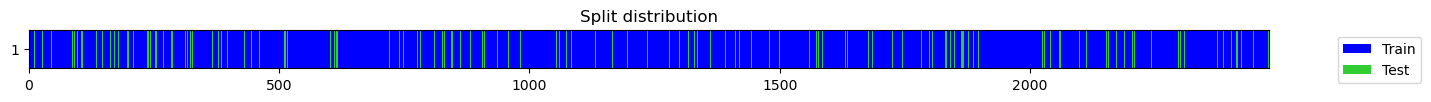

X.shape: (2476, 1, 25)
y.shape: (2476, 1, 25)


In [16]:
#Split dataset
random.seed = config.random_seed
if config.valid_artifact:
    X, y, splits  = combine_split_data(xs=[X_train, X_valid], ys=[X_train, X_valid])
else:
    X = X_train
    y = X_train
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size)
splits
print("X.shape: "+str(X.shape))
print("y.shape: "+str(y.shape))
#print(splits)

In [17]:
#Create and train the model
#features = pd.DataFrame(dls.dataset[0][0])
#targets = pd.DataFrame(dls.dataset[0][1]) #1

#print("dls len: " + str(len(dls.dataset)))

#print("Features shape: " + str(features.shape))
#print("Targets shape: " + str(features.shape))

#dls.dataset

In [18]:

num_vars = 1
#numLags         = X_train.shape[0] #config.epochs
nDimInput       = num_inputs
nDimOutput      = num_vars
numNeurons      = config.numHiddenNeurons #nDimInput  #config.numHiddenNeurons
algorithm       = config.algorithm
LN              = config.LN 
AE              = config.AE
InWeightFF      = config.inputWeightForgettingFactor #1.0
OutWeightFF     = config.outputWeightForgettingFactor #0.92
HiddenWeightFF  = config.inputWeightForgettingFactor #1.0
lamb            = config.lamb
predictionStep  = config.stride #5


In [19]:

data_to_append = {
    "Description": [
        "inputs/Charasteristics", 
        "Targets shape", 
        "X_train shape", 
        "Input Weights", 
        "Hidden Weights", 
        "Hidden A", 
        "Bias", 
        "Features"
    ],
    "Value": [
        str(nDimInput),
        str(y.shape),
        str(X_train.shape),
        f"({numNeurons}, {nDimInput})",
        f"({numNeurons}, {numNeurons})",
        f"({nDimOutput}, {numNeurons})",
        f"({nDimOutput}, {numNeurons})",
        f"({nDimOutput}, {nDimInput})"
    ]
}
data_to_append = pd.DataFrame(data_to_append)
training_info = training_info.append(data_to_append, ignore_index = True)
training_info.head

<bound method NDFrame.head of                   Description          Value
0               Dataset shape      (2500, 1)
1   Number of Sliding windows           2476
2        Sliding window shape        (1, 25)
3      inputs/Charasteristics              1
4               Targets shape  (2476, 1, 25)
5               X_train shape  (2476, 1, 25)
6               Input Weights        (25, 1)
7              Hidden Weights       (25, 25)
8                    Hidden A        (1, 25)
9                        Bias        (1, 25)
10                   Features         (1, 1)>

Train the model with fastai Learner class, to abstract from Pytorch's training loop




To track the performance of this model fit, go to the project dashboard in Weights & Biases. The link is provided at the beginning of this notebook, after the execution of the function `wandb.init()'' 

Finally, log the learner to be used by the next notebook in the pipeline

In [20]:
"""
m = orelm.ORELM_torch(
    inputs                      =   X_train.shape[2], #nDimInput,
    outputs                     =   nDimOutput,
    numHiddenNeurons            =   config.numHiddenNeurons,
    activationFunction          =   config.activationFunction,
    LN                          =   config.LN,
    AE                          =   config.AE,
    ORTH                        =   config.ORTH,
    inputWeightForgettingFactor =   config.inputWeightForgettingFactor,
    outputWeightForgettingFactor=   config.outputWeightForgettingFactor,
    seq_len                     =   config.w
)
m.initializePhase(lamb=0.0001)
print(m)
"""

'\nm = orelm.ORELM_torch(\n    inputs                      =   X_train.shape[2], #nDimInput,\n    outputs                     =   nDimOutput,\n    numHiddenNeurons            =   config.numHiddenNeurons,\n    activationFunction          =   config.activationFunction,\n    LN                          =   config.LN,\n    AE                          =   config.AE,\n    ORTH                        =   config.ORTH,\n    inputWeightForgettingFactor =   config.inputWeightForgettingFactor,\n    outputWeightForgettingFactor=   config.outputWeightForgettingFactor,\n    seq_len                     =   config.w\n)\nm.initializePhase(lamb=0.0001)\nprint(m)\n'

In [21]:
tfms = [ToFloat(), ToFloat()]
batch_tfms = [TSStandardize(by_sample=True)]

print("X_train shape[0]: " + str(X_train.shape[0]))
print("X.shape: "+str(X.shape))
print("y.shape: "+str(y.shape))
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms) #Por defecto bs = 64, pero da problemas al entrenar
print("dls.shape: "+str(X.shape))
print("Last dls.shape: "+str(X[-1].shape))
print(dls.train, len(dls.train))
print("dls.bs ", dls.bs)

X_train shape[0]: 2476
X.shape: (2476, 1, 25)
y.shape: (2476, 1, 25)
idx  slice(None, None, None)
is indexer idx:  False
--> foundations: _get self: [ToFloat:
encodes: (Tensor,object) -> encodes
(object,object) -> encodes
decodes: (object,object) -> decodes
]
Index  slice(None, None, None)
Atrs:  [ToFloat:
encodes: (Tensor,object) -> encodes
(object,object) -> encodes
decodes: (object,object) -> decodes
]
idx  0
is indexer idx:  True
--> foundations: _get self: [[793, 1809, 176, 1111, 1097, 133, 927, 1905, 1480, 418, 1709, 1276, 2380, 1184, 2183, 2042, 1226, 109, 1371, 1210, 2143, 438, 1607, 498, 2104, 1128, 2178, 415, 1929, 178, 258, 1368, 1440, 1178, 57, 2355, 39, 1787, 1907, 2346, 2379, 653, 2230, 1151, 772, 1489, 1933, 1090, 1342, 1189, 999, 311, 1221, 1211, 2218, 1124, 2146, 2283, 1300, 2036, 365, 755, 869, 1629, 1701, 1409, 1599, 1785, 2132, 2351, 193, 207, 1794, 2360, 1641, 321, 2128, 1755, 1036, 103, 695, 915, 833, 709, 2326, 2110, 2077, 1593, 475, 1693, 1110, 1148, 1729, 1113,

In [22]:

m = orelm.ORELM_torch(
    inputs                      =   nDimInput, #X_train.shape[2]
    outputs                     =   nDimOutput,
    numHiddenNeurons            =   config.numHiddenNeurons,
    activationFunction          =   config.activationFunction,
    LN                          =   config.LN,
    AE                          =   config.AE,
    ORTH                        =   config.ORTH,
    inputWeightForgettingFactor =   config.inputWeightForgettingFactor,
    outputWeightForgettingFactor=   config.outputWeightForgettingFactor,
    seq_len                     =   config.w
)
m.initializePhase(lamb=0.0001)
print(m)

inputs: 1
outputs: 1
numNeurons: 25
Out weight FF: 0.92
Window size: 25
(25, 1)
orelm-H ~  torch.Size([1, 25])
-------- num_inputs, window_size = 1,25
Foselm -- before bias
Foselm -- before beta
input FOSELM model FOSELM_torch()
input, output 1 1
Foselm -- before bias
Foselm -- before beta
Output FOSELM model FOSELM_torch()
input, output 25 25
--> Initialize_Phase: Input Weights initialized. Shape: torch.Size([25, 1])
Foselm - initialize phase
Foselm - initialize phase
ORELM_torch(
  (inputAE): FOSELM_torch()
  (hiddenAE): FOSELM_torch()
)


In [23]:
dls.bs

64

In [24]:
#Build learner
learn =  Learner(
    dls         = dls, 
    model       = m, 
    loss_func   = orelm.mse.MSELoss0 #nn.MSELoss(), #
    opt_func    = Adam, #Creates an optimizer
    cbs         = [WandbCallback(log_preds=False)], #List of callbacks,
)

print(type(dls))
print(type(m))
print(m)
print(type(learn))
print(dir(learn))
print(learn.cbs)


Initialize loss function
<class 'tsai.data.core.TSDataLoaders'>
<class 'nbs.orelm.orelm_torch.ORELM_torch'>
ORELM_torch(
  (inputAE): FOSELM_torch()
  (hiddenAE): FOSELM_torch()
)
<class 'fastai.learner.Learner'>
['AE', 'H', 'LN', 'M', 'ORTH', 'T_destination', '_ORELM_torch__calculateHiddenWeightsUsingAE', '_ORELM_torch__calculateInputWeightsUsingAE', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__stored_args__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward', '_backward_hooks', '_bn_bias_state', '_buffers', '_call_impl', '_call_one', '_component_attr_filter', '_default', '_dir', '_do_epoch', '_do_epoch_train', '_do_epoch_validate', 

In [25]:
print("Tasa de aprendizaje actual:", learn.lr)


Tasa de aprendizaje actual: 0.001


In [26]:
"""
#### Prueba comprobar tamaños para m "en pequeño"
step = 0
predictions = []
target = []
maxStep = X.shape[0]
for i in range(maxStep-1):
    training_dataset = X[i]
    targets = y[i]
    features = X[i+1] 
    print("Training["+str(i)+"] shape: " + str(training_dataset.shape))
    print("Targets["+str(i)+"] shape: " + str(targets.shape))
    m.train(training_dataset, targets)
    Y = m.predict(features)
    predictions.append(Y[0][0])
    target.append(y[i+1][0])
    print (str(step)+"th/"+str(maxStep)+" ("+str(i)+") timeStep of "+str(maxStep) +" -  target: "+str(target[i]) + " |    prediction: "+str(predictions[-1]))
"""

'\n#### Prueba comprobar tamaños para m "en pequeño"\nstep = 0\npredictions = []\ntarget = []\nmaxStep = X.shape[0]\nfor i in range(maxStep-1):\n    training_dataset = X[i]\n    targets = y[i]\n    features = X[i+1] \n    print("Training["+str(i)+"] shape: " + str(training_dataset.shape))\n    print("Targets["+str(i)+"] shape: " + str(targets.shape))\n    m.train(training_dataset, targets)\n    Y = m.predict(features)\n    predictions.append(Y[0][0])\n    target.append(y[i+1][0])\n    print (str(step)+"th/"+str(maxStep)+" ("+str(i)+") timeStep of "+str(maxStep) +" -  target: "+str(target[i]) + " |    prediction: "+str(predictions[-1]))\n'

In [27]:
lr_valley, lr_steep = learn.lr_find(suggest_funcs=[valley, steep]) 

... Enabling Vs Code execution ...
--> all_batches
--> all_batch before enumerate self.dl loop n_iter 34
idx  0
is indexer idx:  True
--> foundations: _get self: [TSTfmdLists: [[[-0.44675405  0.12501063 -0.78981285 ... -1.47593047 -0.56110698
   -0.10369524]]

 [[ 0.01065769  0.58242237 -1.81898927 ... -1.93334221 -1.5902834
   -0.90416579]]

 [[-0.78981285 -0.33240111 -1.24722459 ...  0.12501063  0.69677531
    0.92548118]]

 ...

 [[-2.27640101 -1.13287166 -2.27640101 ...  0.23936356  1.15418705
    1.03983411]]

 [[-0.44675405  2.18336346 -1.36157753 ...  0.23936356  0.58242237
    1.03983411]]

 [[ 1.38289292 -0.33240111  0.23936356 ...  0.46806943 -0.90416579
   -1.5902834 ]]]
tfms - [ToFloat:
encodes: (Tensor,object) -> encodes
(object,object) -> encodes
decodes: (object,object) -> decodes
], TSTfmdLists: [[[-0.44675405  0.12501063 -0.78981285 ... -1.47593047 -0.56110698
   -0.10369524]]

 [[ 0.01065769  0.58242237 -1.81898927 ... -1.93334221 -1.5902834
   -0.90416579]]

 [[-0.78

IndexError: Exception occured in `Recorder` when calling event `after_batch`:
	list index out of range

In [ ]:
"""
#print("self.dls shape: " + str(learn.dls.train.shape))
#print("self.dls.train " + str(len(learn.dls.train)))

"""
import sys

# Abre un archivo para redirigir la salida de print


#cprofiler = cProfile.Profile()

import traceback as tr
try:
    print(learn.lr)
    lr_valley, lr_steep = learn.lr_find(suggest_funcs=[valley, steep]) 
    #lr_valley, lr_steep = learn.lr_find(suggest_funcs=[valley, steep], start_lr=1e-7, end_lr=10) 
except Exception as e:
    exc_type, exc_value, exc_traceback = sys.exc_info()
    #error_message = ''.join(sys.format_exception(exc_type, exc_value, exc_traceback))
    error_message = ''.join(tr.format_exception(exc_type, exc_value, exc_traceback))
    print(error_message)
    exit(0)

#learn.fit_one_cycle(1, lr_max=lr_valley)
#learn.fit_one_cycle(config.epochs, lr_max=lr_valley)
#learn.plot_metrics()


In [ ]:
aux_learn = learn.export_and_get()
if config.use_wandb: 
    ar = ReferenceArtifact(aux_learn, f'dcae', type='learner', metadata=dict(run.config))
    run.log_artifact(ar, aliases=f'run-{run.project}-{run.id}')

# Validate de autoencoder

## Get the best and the worst k predictions using the autoencoder

In [ ]:
import sys 

interp = Interpretation.from_learner(learn)
top_losses = interp.top_losses(3)
top_losses

# Copiando Versión original con pytorch

In [ ]:
#output_file.close()


In [ ]:
"""
import pstats

# Genera el informe de perfil
informe_perfil = pstats.Stats(cprofiler)
informe_perfil.strip_dirs()  # Elimina información de directorios
informe_perfil.sort_stats('cumulative')  # Ordena por tiempo acumulativo
informe_perfil.print_stats()  # Imprime el informe
""" 

In [ ]:
X = torch.Tensor([X[w][0] for w in range(X_train.shape[0])]).float()
T = torch.Tensor([y[w][0] for w in range(X_train.shape[0])]).T.float()   
print('Input shape: ', str(X.shape))
print('Target shape: ', str(T.shape))

In [ ]:
predictions = []
target = []
maxStep = X.shape[1]-predictionStep-1
print("Num steps: " + str(maxStep))

In [ ]:
#import sys

# Abre un archivo para redirigir la salida de print


step = 0
for i in range(maxStep-1):
    
    step += 1
    print ("--> {:5}th/{:5}".format(step,maxStep))    
    sys.stdout.flush()
    training_dataset = (X[[i],:])
    targets = T[[i],:]
    features = X[[i+1],:]
    print("Training["+str(i)+"] shape: " + str(training_dataset.shape))
    print("Targets["+str(i)+"] shape: " + str(targets.shape))
    m.train_func(training_dataset, targets)
    Y = m.predict(features)
    predictions.append(Y[0][0])
    target.append(T[i][0])
    print (str(step)+"th/"+str(maxStep)+" ("+str(i)+") timeStep of "+str(maxStep) +" -  target: "+str(target[i]) + " |    prediction: "+str(predictions[-1]))
#output_file.close()

# Evaluation: Calculate total Normalizedd Root Mean Square Error (NRMSE)

In [ ]:
# Reconstruct original value
predictions = np.array(predictions)
target = np.array(target)
predictions = predictions * stdSeq + meanSeq
target = target * stdSeq + meanSeq
  
def computeSquareDeviation(predictions, truth):
  squareDeviation = np.square(predictions-truth)
  return squareDeviation

# Calculate NRMSE from skip_eval to the end
skip_eval=100
squareDeviation = computeSquareDeviation(predictions, target)
squareDeviation[:skip_eval] = None
nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)
print("NRMSE {}".format(nrmse))

In [ ]:
print("Target len: " + str(len(target)) + str(target))
print("Prediction len: " + str(len(predictions))+str(predictions))

## Plot predictions and target values

In [ ]:

algorithm = config.algorithm
print(algorithm)
print(config.job_type)
plt.figure(figsize=(15,6))

targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
plt.xlim([0, 200])
plt.ylim([60, 100])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+ config.job_type + ' algorithm: ' + algorithm +' on '+dataSet.fname+' dataset' ,fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.savefig(plot_path,bbox_inches='tight')
plt.draw()
plt.show()
plt.pause(0)
print('Prediction plot is saved to'+plot_path)

## Online learning and prediction of OR-ELM

In [ ]:
run.finish()